# Bank Card Binary Choice - Hierarchical Model

Data from trade-off study where participants were shown a choice between two hypothetical bank cards. The two cards were identical in all characteristics except for two.  Each participant evaluated 13-17 paired comparisons 
involving a fraction of attributes. 

The data bank_choice contains columns:

- id: participant identifier
- choice: choice indicator (1=first card; 0=second card)
- remaining columns: x_hi1 - x_hi2, difference in attribute x between card 1 and card 2

The data bank_demo contains columns:

- id: participant identifier
- remaining columns: demographic information

We can model the part-worths of each participant as random effects.

In [1]:
import numpy as np
import pandas as pd
import edward as ed
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
ed.set_seed(42)

In [3]:
bank_choice = pd.read_csv("/Users/hauptjoh/Downloads/bank_choice.csv")
bank_demo = pd.read_csv("/Users/hauptjoh/Downloads/bank_demo.csv", )

In [4]:
print(bank_choice.columns)
print(bank_demo.columns)

Index(['id', 'choice', 'Med_FInt', 'Low_FInt', 'Med_VInt', 'Rewrd_2',
       'Rewrd_3', 'Rewrd_4', 'Med_Fee', 'Low_Fee', 'Bank_B', 'Out_State',
       'Med_Rebate', 'High_Rebate', 'High_CredLine', 'Long_Grace'],
      dtype='object')
Index(['id', 'age', 'income', 'gender'], dtype='object')


In [5]:
bank_demo = pd.merge(pd.DataFrame(bank_choice.id), bank_demo, 
                     left_on="id", right_on="id")

In [6]:
bank_demo.iloc[-3:,]

,id,age,income,gender
14796,1021,60,40,0
14797,1021,60,40,0
14798,1021,60,40,0


Use sklearn to create training and testing set indices by creating a generator and then running the generator to get indices

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit

In [8]:
sss = StratifiedShuffleSplit(n_splits=1, test_size = 0.3, random_state = 123)
train, test = next(sss.split(bank_choice, bank_choice.choice))

Separate the data into the card characteristics (fixed effects) and the user characteristics (random effects)

In [9]:
card = bank_choice.drop(["id", "choice"], axis=1).values
choice = bank_choice.choice.values.flatten()
demo = bank_demo.drop(["id"], axis=1).values

In [10]:
uid = pd.factorize(bank_choice.id)[0]

In [11]:
print(card.shape)
print(uid.shape)
print(demo.shape)
print(choice.shape)

(14799, 14)
(14799,)
(14799, 3)
(14799,)


In [12]:
card_train = card[train,:]
card_test = card[test,:]

choice_train = choice[train]
choice_test = choice[test]

demo_train = demo[train,:]
demo_test = demo[test,:]

uid_train = uid[train]
uid_test = uid[test]

## Bayesian Logit model with random effects

The simple logit model is defined as $P(y_hi=1)=\frac{exp[\beta_0 + (x_{hi1}-x_{hi2})^T\beta]}{1+exp[\beta_0 + (x_{hi1}-x_{hi2})^T\beta]}$. The simple model assumes 1. that the baseline is identical for each user and 2. that the characteristics of each user have the same effect on the customer's choice. The model is called a fixed effects model, because the coefficients are assumed fixed for the population. We'll relax these assumptions by including 1. a bias term for each customer and 2. make the coefficients dependent on the user. Coefficients that vary for individiuals are called random effects.

In [13]:
N = len(train) # Number of observations
D = card.shape[1] # Number of variables
n_users = len(bank_demo.id.unique())

In [14]:
from edward.models import Normal, Bernoulli, Empirical

We have two inputs now, the card characteristics as before and the identity of the customer, which determines their bias term.

In [48]:
X_card = tf.placeholder(tf.float32, [N,D])
X_uid = tf.placeholder(tf.int32, [N])

Accordingly, we replace the population bias term by a bias term for each user.

In [56]:
#b = Normal(loc=tf.zeros([]), scale=3.0 * tf.ones([]))
ub = Normal(loc=tf.zeros(n_users), scale=1.0 * tf.ones(n_users))

For now, we'll keep the other coefficients fixed, as before.

In [57]:
w = Normal(loc=tf.zeros(D), scale=3.0 * tf.ones(D))

y = Bernoulli(logits=ed.dot(X_card, w) + tf.gather(ub, indices = X_uid) )

### Monte Carlo Sampling

In [58]:
T = 20000 # Number of iterations
qw = Empirical(tf.Variable(tf.zeros([T,D])))
#qb = Empirical(tf.Variable(tf.zeros([T,])))
qub = Empirical(tf.Variable(tf.zeros([T,n_users])))

proposal_w = Normal(loc=w, scale = .02)
#proposal_b = Normal(loc=b, scale = .02)
proposal_ub = Normal(loc=ub, scale = .02)

In [59]:
from edward.inferences import MetropolisHastings
inference = MetropolisHastings({w:qw, ub:qub}, 
                               {w:proposal_w, ub:proposal_ub},
                               data={y:choice_train, X_card:card_train, X_uid:uid_train})

In [60]:
inference.run(n_print=1000)

20000/20000 [100%] ██████████████████████████████ Elapsed: 75s | Acceptance Rate: 0.399


### Variational inference

In [ ]:
qw_loc = tf.get_variable("qw_loc", [D])
qw_scale = tf.nn.softplus(tf.get_variable("qw_scale", [D]))

qb_loc = tf.get_variable("qb_loc", [])
qb_scale = tf.nn.softplus(tf.get_variable("qb_scale", []))

qub_loc = tf.get_variable("qub_loc", [n_users])
qub_scale = tf.nn.softplus(tf.get_variable("qub_scale", [n_users]))

In [17]:
#qw_alpha = tf.nn.softplus(tf.get_variable("qw_alpha", [D])) +0.1
#qw_beta = tf.nn.softplus(tf.get_variable("qw_beta", [D]))+0.1
#qb_alpha = tf.nn.softplus(tf.get_variable("qb_alpha", []))+0.1
#qb_beta = tf.nn.softplus(tf.get_variable("qb_beta", []))+0.1

In [18]:
#from edward.models import Beta
#qw = Beta(concentration1=qw_alpha, concentration0=qw_beta)
#qb = Beta(concentration1=qb_alpha, concentration0=qb_beta)

In [18]:
qw = Normal(loc=qw_loc, scale=qw_scale)
qb = Normal(loc=qb_loc, scale=qb_scale)
qub = Normal(loc=qub_loc, scale=qub_scale)

In [21]:
inference = ed.KLqp({w: qw, b: qb, ub: qub}, data={X_card: card[train,:], 
                                          y: choice[train], 
                                          X_uid: uid[train]})

/Users/hauptjoh/anaconda/envs/edward/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \
/Users/hauptjoh/anaconda/envs/edward/lib/python3.6/site-packages/edward/util/random_variables.py:53: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  not np.issubdtype(value.dtype, np.int) and \


In [22]:
inference.run(n_iter = 2000, n_print=100)

2000/2000 [100%] ██████████████████████████████ Elapsed: 9s | Loss: 5721.656


### Model critique

In [61]:
print(n_users)
qub.sample(1000).eval().shape

946


(1000, 946)

In [62]:
random_effects = np.mean( qub.sample(1000).eval() , axis=0)

In [63]:
print(random_effects.shape)
np.percentile(random_effects,[0,25,50,75,100])

(946,)


array([-2.2216537 , -0.45124401, -0.00359018,  0.42809447,  1.99584985])

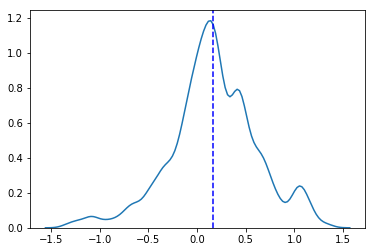

In [72]:
b01 = qub.sample(10000).eval()[:,5]
var_plot = sns.kdeplot(data=b01)
plt.axvline(x=np.mean(b01), color = "blue", linestyle="dashed")
plt.show()

In [73]:
yhat = y.sample(30000, ).eval({X_card:card_train, X_uid: uid_train})
yhat.shape

(30000, 10359)

In [74]:
yhat = np.asarray(yhat)

In [75]:
probs = np.mean(yhat, axis = 0)

In [76]:
from sklearn.metrics import confusion_matrix, roc_auc_score
print(roc_auc_score(choice_train, probs))

0.5164134111884165


In [77]:
X_card_test = tf.placeholder(tf.float32, [len(test),D])
X_uid_test = tf.placeholder(tf.int32, len(test))

y_post = Bernoulli(logits=ed.dot(X_card_test, w) + tf.gather(ub, indices = X_uid_test) )

In [78]:
yhat = y_post.sample(10000, ).eval({X_card_test:card_test, X_uid_test: uid_test})
yhat.shape

(10000, 4440)

In [79]:
yhat = np.asarray(yhat)

In [80]:
probs = np.mean(yhat, axis = 0)

In [81]:
probs[0:10]

array([0.4616, 1.    , 0.9995, 0.0021, 0.0061, 0.9493, 0.    , 0.9999,
       0.0349, 0.8781])

In [82]:
np.percentile(probs,[0,25,50,75,100])

array([0.0000e+00, 8.0000e-04, 7.3500e-02, 9.2515e-01, 1.0000e+00])

Need to evaluate the tensor. Any tensor is also a numpy array.

In [83]:
from sklearn.metrics import confusion_matrix, roc_auc_score
print(roc_auc_score(choice_test, probs))

0.49042117318983924


### Hamilton Monte Carlo

In [28]:
# INFERENCE
T = 1000 # Number of posterior samples
qw = Empirical(params=tf.get_variable("qw/params", [T, D]))
qb = Empirical(params=tf.get_variable("qb/params", [T]))

In [31]:
inference = ed.HMC({w: qw, b: qb}, data={X: X_train, y: y_train})

/Users/hauptjoh/anaconda/envs/edward/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \
/Users/hauptjoh/anaconda/envs/edward/lib/python3.6/site-packages/edward/util/random_variables.py:53: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  not np.issubdtype(value.dtype, np.int) and \


In [44]:
inference.initialize(n_print=10, step_size=0.01)
tf.global_variables_initializer().run()

In [45]:
inference.run()

1000/1000 [100%] ██████████████████████████████ Elapsed: 6s | Acceptance Rate: 0.000
